In [252]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

base_dir = "/".join(os.getcwd().split("/")[:-1])

In [255]:
def read_experiment(base_dir, acquisition, objective, seed, suffix):
    
    file = f"{base_dir}/experiments/{acquisition}/{objective}/seed-{seed}{suffix}/log-regret.txt"
    df = pd.read_csv(file, sep=', ', header=None, engine="python")
    
    num_bo_steps = df[0].values
    num_points = df[1].values
    log10_regret = df[2].values
    
    return num_bo_steps, num_points, log10_regret

In [257]:
seeds = list(range(4, 10))

acquisitions = [
    ("random", "_batch_size-20"),
    ("thompson", "_batch_size-20"),
    ("ei", ""),
    ("mcei", "_batch_size-20_num_mcei_samples-1"),
    ("mcei", "_batch_size-20_num_mcei_samples-100"),
    ("mcei", "_batch_size-20_num_mcei_samples-1000"),
    ("amcei", "_batch_size-20_num_mcei_samples-1000"),
]

objective = "matern52_4_0"

results = {}

for acquisition, suffix in acquisitions:
    
    regret = []
    results[acquisition + suffix] = {}
    
    for seed in seeds:
    
        num_bo_steps, num_points, log10_regret = read_experiment(
            base_dir=base_dir,
            acquisition=acquisition,
            objective=objective,
            seed=seed,
            suffix=suffix,
        )
        
        regret.append(10**log10_regret)
        
    results[acquisition + suffix]["num_bo_steps"] = num_bo_steps
    results[acquisition + suffix]["num_points"] = num_points
    results[acquisition + suffix]["regret"] = np.stack(regret, axis=0)
    results[acquisition + suffix]["mean_regret"] = np.mean(regret, axis=0)
    results[acquisition + suffix]["median_regret"] = np.median(regret, axis=0)
    results[acquisition + suffix]["stddev_regret"] = np.var(regret, axis=0)**0.5
    results[acquisition + suffix]["uq_regret"] = np.quantile(regret, 0.975, axis=0) / len(seeds)**0.5
    results[acquisition + suffix]["lq_regret"] = np.quantile(regret, 0.025, axis=0) / len(seeds)**0.5

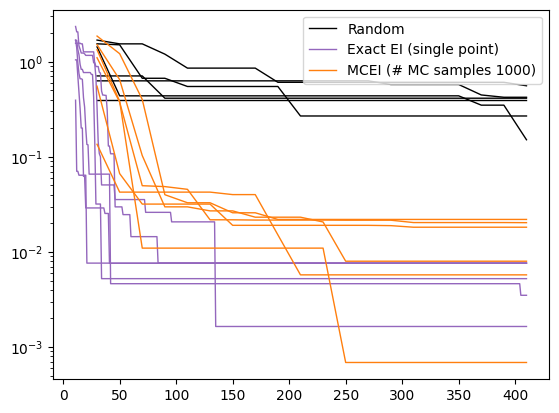

In [272]:
acquisitions = [
    [("random", "_batch_size-20"), "Random", "black"],
    # [("thompson", "_batch_size-20"), "Thompson", "tab:blue"],
    [("ei", ""), "Exact EI (single point)", "tab:purple"],
    # [("mcei", "_batch_size-20_num_mcei_samples-1"), "MCEI (# MC samples 1)", "tab:red"],
    # [("mcei", "_batch_size-20_num_mcei_samples-100"), "MCEI (# MC samples 100)", "tab:green"],
    [("mcei", "_batch_size-20_num_mcei_samples-1000"), "MCEI (# MC samples 1000)", "tab:orange"],
    # [("amcei", "_batch_size-20_num_mcei_samples-1000"), "AMCEI (# MC samples 1000)", "tab:cyan"],
]

for ((acquisition, suffix), name, color) in acquisitions:
    
    regret = results[acquisition + suffix]["regret"].T
    mean_regret = results[acquisition + suffix]["mean_regret"].T
    median_regret = results[acquisition + suffix]["median_regret"]
    num_points = results[acquisition + suffix]["num_points"]
    num_bo_steps = results[acquisition + suffix]["num_bo_steps"]
    uq_regret = results[acquisition + suffix]["uq_regret"]
    lq_regret = results[acquisition + suffix]["lq_regret"]
    stddev_regret = results[acquisition + suffix]["stddev_regret"]
    
    for i in range(len(seeds)):
        
        if i == seeds[0]:
            plt.plot(num_points, regret[:, i], color=color, linewidth=1, label=name)
        
        else:
            plt.plot(num_points, regret[:, i], color=color, linewidth=1)
    
plt.yscale("log")
plt.legend()
plt.show()

In [213]:
seeds = list(range(5))

acquisitions = [
    ("random", "_batch_size-20"),
    ("thompson", "_batch_size-20"),
    ("ei", ""),
    ("mcei", "_batch_size-20_num_mcei_samples-1"),
    ("mcei", "_batch_size-20_num_mcei_samples-100"),
    ("mcei", "_batch_size-20_num_mcei_samples-1000"),
]

objective = "matern52_6_0"

results = {}

for acquisition, suffix in acquisitions:
    
    regret = []
    results[acquisition + suffix] = {}
    
    for seed in seeds:
    
        num_bo_steps, num_points, log10_regret = read_experiment(
            base_dir=base_dir,
            acquisition=acquisition,
            objective=objective,
            seed=seed,
            suffix=suffix,
        )
        
        regret.append(10**log10_regret)
        
    results[acquisition + suffix]["num_bo_steps"] = num_bo_steps
    results[acquisition + suffix]["num_points"] = num_points
    results[acquisition + suffix]["regret"] = np.stack(regret, axis=0)
    results[acquisition + suffix]["mean_regret"] = np.mean(regret, axis=0)
    results[acquisition + suffix]["median_regret"] = np.median(regret, axis=0)
    results[acquisition + suffix]["stddev_regret"] = np.var(regret, axis=0)**0.5
    results[acquisition + suffix]["uq_regret"] = np.quantile(regret, 0.975, axis=0) / len(seeds)**0.5
    results[acquisition + suffix]["lq_regret"] = np.quantile(regret, 0.025, axis=0) / len(seeds)**0.5

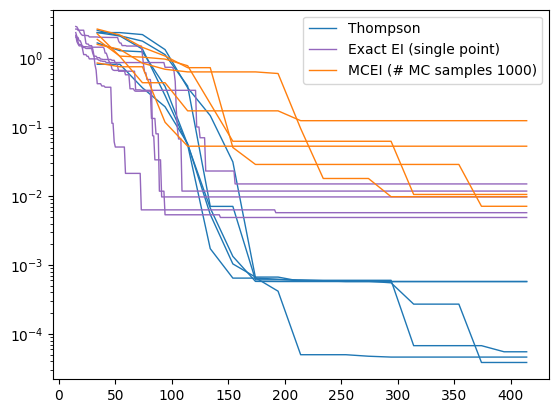

In [214]:
acquisitions = [
    # [("random", "_batch_size-20"), "Random", "black"],
    [("thompson", "_batch_size-20"), "Thompson", "tab:blue"],
    [("ei", ""), "Exact EI (single point)", "tab:purple"],
    # [("mcei", "_batch_size-20_num_mcei_samples-1"), "MCEI (# MC samples 1)", "tab:red"],
    # [("mcei", "_batch_size-20_num_mcei_samples-100"), "MCEI (# MC samples 100)", "tab:green"],
    [("mcei", "_batch_size-20_num_mcei_samples-1000"), "MCEI (# MC samples 1000)", "tab:orange"],
]

for ((acquisition, suffix), name, color) in acquisitions:
    
    regret = results[acquisition + suffix]["regret"].T
    mean_regret = results[acquisition + suffix]["mean_regret"].T
    median_regret = results[acquisition + suffix]["median_regret"]
    num_points = results[acquisition + suffix]["num_points"]
    num_bo_steps = results[acquisition + suffix]["num_bo_steps"]
    uq_regret = results[acquisition + suffix]["uq_regret"]
    lq_regret = results[acquisition + suffix]["lq_regret"]
    stddev_regret = results[acquisition + suffix]["stddev_regret"]
    
    for i in seeds:
        
        if i == 0:
            plt.plot(num_points, regret[:, i], color=color, linewidth=1, label=name)
        
        else:
            plt.plot(num_points, regret[:, i], color=color, linewidth=1)
    
plt.yscale("log")
plt.legend()
plt.show()